<a href="https://colab.research.google.com/github/sk643666/AIFFEL_quest_cr/blob/master/test_src/YYY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Name: pymunk
Version: 6.10.0
Summary: Pymunk is a easy-to-use pythonic 2D physics library
Home-page: https://www.pymunk.org
Author: 
Author-email: Victor Blomqvist <vb@viblo.se>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: cffi
Required-by: 

0: 736x1280 1 frame, 1 red ball, 1 table, 1 white ball, 1 yellow ball, 1442.0ms
Speed: 11.4ms preprocess, 1442.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


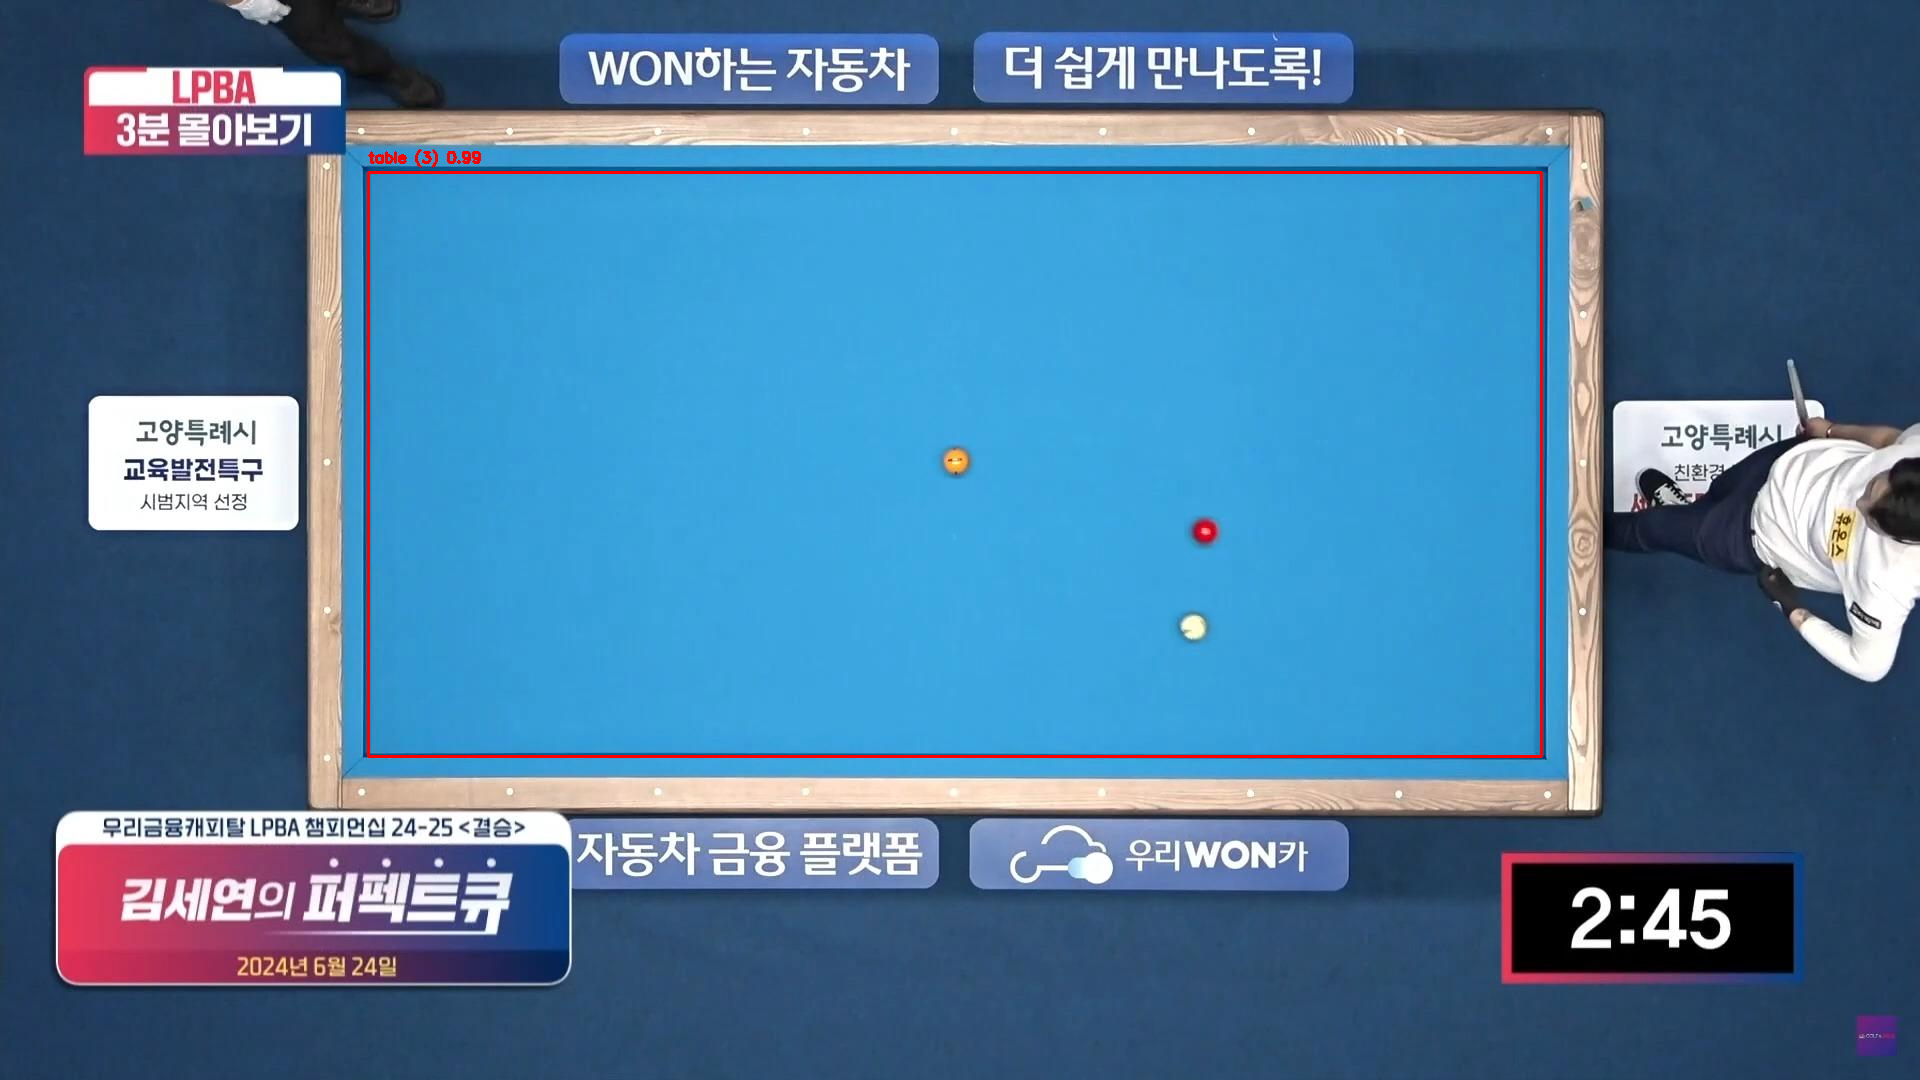

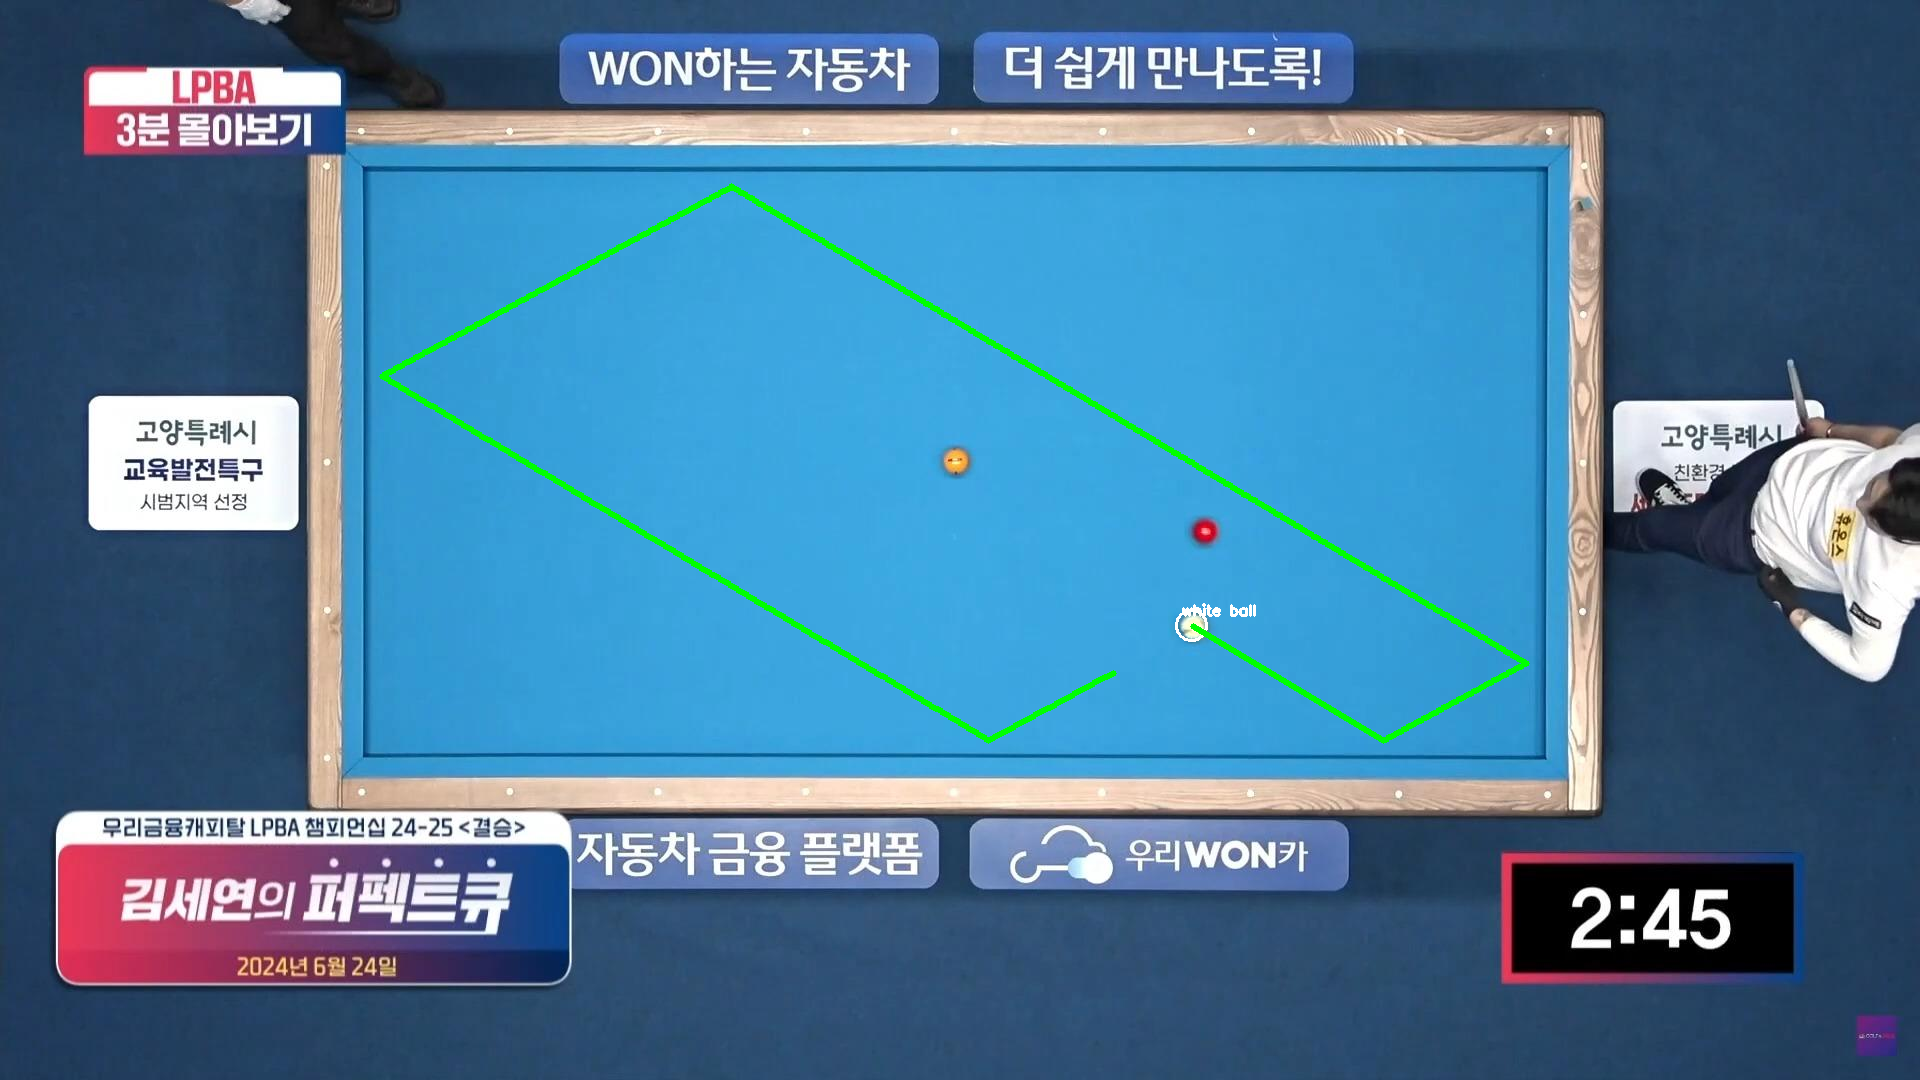

In [2]:
from google.colab import drive
drive.mount('/content/drive')


!pip install pymunk
!pip install ultralytics
!pip show pymunk


import cv2
from ultralytics import YOLO
import pymunk
from pymunk import Vec2d
from google.colab.patches import cv2_imshow

# YOLO 모델 로드 및 이미지 읽기
model = YOLO("JJJ.pt")
image_path = 'MMM.jpg'
image = cv2.imread(image_path)
process_ball_info = "white ball"

# YOLO 모델로 이미지 분석
results = model(image)
class_names = model.names
output_image = image.copy()

# 테이블 박스 초기화 및 탐지
table_box = None
for detection in results[0].boxes:
    box = detection.xyxy[0].tolist()
    class_id = int(detection.cls[0])
    confidence = detection.conf[0]
    class_name = class_names[class_id]
    if class_name == "table":
        table_box = box
        cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
        text = f"{class_name} ({class_id}) {confidence:.2f}"
        cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

cv2_imshow(output_image)

# 공 탐지 및 그리기 함수
def detector_org_cuball(image, target_ball_info):
    color_map = {
        "yellow ball": (0, 255, 255),
        "white ball": (255, 255, 255)
    }
    for detection in results[0].boxes:
        box = detection.xyxy[0].tolist()
        class_id = int(detection.cls[0])
        class_name = class_names[class_id]
        if class_name == target_ball_info:
            x = int((box[0] + box[2]) // 2)
            y = int((box[1] + box[3]) // 2)
            radius = int((box[2] - box[0]) // 2)
            if target_ball_info in color_map:
                cv2.circle(image, (x, y), radius, color_map[target_ball_info], 2)
                cv2.putText(image, f"{target_ball_info}", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_map[target_ball_info], 2)
            return (x, y), radius
    return None, None

# Pymunk 물리 엔진 초기화
def setup_physics(space, table_box):
    space.gravity = (0, 0)
    t_x1, t_y1, t_x2, t_y2 = map(int, table_box)
    static_lines = [
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x2, t_y1), 1),
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x1, t_y2), 1),
        pymunk.Segment(space.static_body, (t_x2, t_y1), (t_x2, t_y2), 1),
        pymunk.Segment(space.static_body, (t_x1, t_y2), (t_x2, t_y2), 1),
    ]
    for line in static_lines:
        line.elasticity = 0.95  # 현실적인 반발 계수로 조정
        space.add(line)

# 경로 시뮬레이션 함수
def simulate_bounce_path(space, start_pos, radius_new, velocity, table_box, max_bounces):
    body = pymunk.Body(mass=1, moment=10)
    body.position = start_pos
    body.velocity = velocity
    ball = pymunk.Circle(body, radius_new)
    ball.elasticity = 0.95
    space.add(body, ball)
    trajectory_points = []
    bounces = 0
    for _ in range(1000):  # 더 긴 반복으로 경로 추적
        space.step(0.005)  # 더 작은 시간 단위로 시뮬레이션 정확도 증가
        trajectory_points.append((int(body.position.x), int(body.position.y)))
        if (body.position.x <= table_box[0] or body.position.x >= table_box[2] or
            body.position.y <= table_box[1] or body.position.y >= table_box[3]):
            bounces += 1
            if bounces >= max_bounces:
                break
    return trajectory_points

# Pymunk 공간 생성 및 시뮬레이션 실행
space = pymunk.Space()
if table_box:
    setup_physics(space, table_box)

start_pos, radius_new = detector_org_cuball(image, process_ball_info)
if start_pos:
    trajectory = simulate_bounce_path(space, start_pos, radius_new, (500, 300), list(map(int, table_box)), 4)
    for point in trajectory:
        cv2.circle(image, point, 3, (0, 255, 0), -1)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
